# Assignment 2 - DS4Biz Y63
## TextScraping_Classification
***

### Team Detail
**Team Name**: sompinandsomshine   
***
### *Student 1*
**Student ID**: 61070278   
**Student Full Name**: นายกิตติภณ สุรุ่งเรืองสกุล
***
### *Student 2*
**Student ID**: 61070330   
**Student Full Name**: นางสาวอิงฟ้า ภูติวรนาถ
***

#### link: https://quotes.toscrape.com/

# Data Collection

In [1]:
import requests
#https://requests.readthedocs.io/en/master/
import bs4
#https://www.crummy.com/software/BeautifulSoup/bs4/doc/

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV


from sklearn.neighbors import KNeighborsClassifier
# import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [2]:
response = requests.get('https://quotes.toscrape.com/page/1/')
print(response)
print(type(response))
html_page = bs4.BeautifulSoup(response.content, 'html.parser')
# print(html_page)

<Response [200]>
<class 'requests.models.Response'>


In [3]:
list_page = []
cur = 1
while 1:
    url = 'https://quotes.toscrape.com/page/'+str(cur)+'/'
    response = requests.get(url)
    html_page = bs4.BeautifulSoup(response.content, 'html.parser')
    selector = 'body > div > div:nth-child(2) > div.col-md-8'
    tag = html_page.select_one(selector)
    if 'No quotes found!' in tag.text:
        break
    else:
        list_page.append(url)
        cur += 1


In [4]:
list_page

['https://quotes.toscrape.com/page/1/',
 'https://quotes.toscrape.com/page/2/',
 'https://quotes.toscrape.com/page/3/',
 'https://quotes.toscrape.com/page/4/',
 'https://quotes.toscrape.com/page/5/',
 'https://quotes.toscrape.com/page/6/',
 'https://quotes.toscrape.com/page/7/',
 'https://quotes.toscrape.com/page/8/',
 'https://quotes.toscrape.com/page/9/',
 'https://quotes.toscrape.com/page/10/']

In [5]:
df = pd.DataFrame(columns=['content','author','tags', 'link_author'])
df

,content,author,tags,link_author


In [6]:
# Content
def extract_content(html_page):
    selector = 'div.col-md-8 > div > span.text'
    tags = html_page.select(selector)
    content = []
    
    for tag in tags:
        content.append(tag.text.strip().replace('“', '').replace('”', ''))
        
    return content

In [7]:
# Author
def extract_author(html_page):
    selector = 'div.col-md-8 > div > span > small'
    tags = html_page.select(selector)
    author = []
    
    for tag in tags:
        author.append(tag.text.strip().replace('-', ' '))
        
    return author

In [8]:
# tags
def extract_tags(html_page):
    selector = 'div.col-md-8 > div > div > meta'
    tags = html_page.select(selector)
    quote_tags = []
    
    for tag in tags:
#         print(tag['content'])
        quote_tags.append(tag['content'])
        
    return quote_tags

In [9]:
# link_author
def extract_link_author(html_page):
    selector = 'div.col-md-8 > div > span > a'
    tags = html_page.select(selector)
    link_author = []
    
    for tag in tags:
#         print(tag['content'])
        link_author.append('https://quotes.toscrape.com/author/' + tag['href'].split('/')[-1] + '/')
        
    return link_author

In [10]:
# response = requests.get('https://quotes.toscrape.com/page/1/')
# html_page = bs4.BeautifulSoup(response.content, 'html.parser')

# extract_content(html_page)

In [11]:
def extract_quotes(url):
    response = requests.get(url)
    html_page = bs4.BeautifulSoup(response.content, 'html.parser')

    content = extract_content(html_page)
    author = extract_author(html_page)
    tags = extract_tags(html_page)
    link_author = extract_link_author(html_page)
    
    Alltags = {'content':content,'author':author,'tags':tags,'link_author':link_author}
    result = pd.DataFrame(Alltags)
    return result

In [12]:
for url in list_page:
    result = extract_quotes(url)
    df = df.append(result, ignore_index=True)
df.head()

,content,author,tags,link_author
0,The world as we have created it is a process o...,Albert Einstein,"change,deep-thoughts,thinking,world",https://quotes.toscrape.com/author/Albert-Eins...
1,"It is our choices, Harry, that show what we tr...",J.K. Rowling,"abilities,choices",https://quotes.toscrape.com/author/J-K-Rowling/
2,There are only two ways to live your life. One...,Albert Einstein,"inspirational,life,live,miracle,miracles",https://quotes.toscrape.com/author/Albert-Eins...
3,"The person, be it gentleman or lady, who has n...",Jane Austen,"aliteracy,books,classic,humor",https://quotes.toscrape.com/author/Jane-Austen/
4,"Imperfection is beauty, madness is genius and ...",Marilyn Monroe,"be-yourself,inspirational",https://quotes.toscrape.com/author/Marilyn-Mon...


In [13]:
df.isna().sum()

content        0
author         0
tags           0
link_author    0
dtype: int64

## author

In [14]:
# df_author = pd.DataFrame(columns=['Born_date','Born_location','Author_description'])
# df_author

In [15]:
# df['Link_author'].iloc[0]

In [16]:
# author born date
def born_date(html_page):
    born_date = html_page.findAll("span", {"class": "author-born-date"})
    born_date = born_date[0].text.replace(',', '').replace(' ', '-')
    return born_date

In [17]:
# author born location
def born_location(html_page):
    born_location = html_page.findAll("span", {"class": "author-born-location"})
    born_location = born_location[0].text.replace(',', '|')
    return born_location

In [18]:
# author Description
def description(html_page):
    description = html_page.findAll("div", {"class": "author-description"})
    description = description[0].text.strip()
    return description

In [19]:
# author Description
def author_name(html_page):
    author_name = html_page.findAll("h3", {"class": "author-title"})
    author_name = author_name[0].text.strip().replace('-', ' ')
    return author_name

In [20]:
# def extract_author(url):
#     response = requests.get(url)
#     html_page = bs4.BeautifulSoup(response.content, 'html.parser')

#     date = born_date(html_page)
#     location = born_location(html_page)
#     description_text = description(html_page)
    
#     Alldetail = {'Born_date': date, 'Born_location': location, 'Author_description':description_text}
#     result = pd.DataFrame(Alldetail)
#     return result

In [21]:
list_born_date = []
list_born_location = []
list_description = []
list_author_name = []

for link_author in list(df['link_author'].unique()):
    
#     response = requests.get('https://quotes.toscrape.com/author/Albert-Einstein/')
    response = requests.get(link_author)
    html_page = bs4.BeautifulSoup(response.content, 'html.parser')
    
    list_born_date.append(born_date(html_page))
    list_born_location.append(born_location(html_page))
    list_description.append(description(html_page))
    list_author_name.append(author_name(html_page))

In [22]:
Alldetail = {'author': list_author_name, 'born_date': list_born_date, 'born_location': list_born_location, 'author_description':list_description}
author_df = pd.DataFrame(Alldetail)

In [23]:
author_df.head()

,author,born_date,born_location,author_description
0,Albert Einstein,March-14-1879,in Ulm| Germany,"In 1879, Albert Einstein was born in Ulm, Germ..."
1,J.K. Rowling,July-31-1965,in Yate| South Gloucestershire| England| The U...,See also: Robert GalbraithAlthough she writes ...
2,Jane Austen,December-16-1775,in Steventon Rectory| Hampshire| The United Ki...,Jane Austen was an English novelist whose work...
3,Marilyn Monroe,June-01-1926,in The United States,Marilyn Monroe (born Norma Jeane Mortenson; Ju...
4,André Gide,November-22-1869,in Paris| France,André Paul Guillaume Gide was a French author ...


In [24]:
df.head()

,content,author,tags,link_author
0,The world as we have created it is a process o...,Albert Einstein,"change,deep-thoughts,thinking,world",https://quotes.toscrape.com/author/Albert-Eins...
1,"It is our choices, Harry, that show what we tr...",J.K. Rowling,"abilities,choices",https://quotes.toscrape.com/author/J-K-Rowling/
2,There are only two ways to live your life. One...,Albert Einstein,"inspirational,life,live,miracle,miracles",https://quotes.toscrape.com/author/Albert-Eins...
3,"The person, be it gentleman or lady, who has n...",Jane Austen,"aliteracy,books,classic,humor",https://quotes.toscrape.com/author/Jane-Austen/
4,"Imperfection is beauty, madness is genius and ...",Marilyn Monroe,"be-yourself,inspirational",https://quotes.toscrape.com/author/Marilyn-Mon...


In [25]:
# df.set_index('Author').join(other.set_index('key'))

In [26]:
# result['Author'].value_counts()

In [27]:
content_author_df = pd.merge(df, author_df, on='author', how='left')
content_author_df.head()

,content,author,tags,link_author,born_date,born_location,author_description
0,The world as we have created it is a process o...,Albert Einstein,"change,deep-thoughts,thinking,world",https://quotes.toscrape.com/author/Albert-Eins...,March-14-1879,in Ulm| Germany,"In 1879, Albert Einstein was born in Ulm, Germ..."
1,"It is our choices, Harry, that show what we tr...",J.K. Rowling,"abilities,choices",https://quotes.toscrape.com/author/J-K-Rowling/,July-31-1965,in Yate| South Gloucestershire| England| The U...,See also: Robert GalbraithAlthough she writes ...
2,There are only two ways to live your life. One...,Albert Einstein,"inspirational,life,live,miracle,miracles",https://quotes.toscrape.com/author/Albert-Eins...,March-14-1879,in Ulm| Germany,"In 1879, Albert Einstein was born in Ulm, Germ..."
3,"The person, be it gentleman or lady, who has n...",Jane Austen,"aliteracy,books,classic,humor",https://quotes.toscrape.com/author/Jane-Austen/,December-16-1775,in Steventon Rectory| Hampshire| The United Ki...,Jane Austen was an English novelist whose work...
4,"Imperfection is beauty, madness is genius and ...",Marilyn Monroe,"be-yourself,inspirational",https://quotes.toscrape.com/author/Marilyn-Mon...,June-01-1926,in The United States,Marilyn Monroe (born Norma Jeane Mortenson; Ju...


## save DataFarame to csv
เพื่อให้ง่ายต่อการใช้ในภายหลัง
- content.csv รายละเอียดของ quote
- author.csv รายละเอียดของผู้เขียน
- content_author.csv รายละเอียดของ quote และผู้เขียน

In [28]:
df.to_csv('content.csv', index=False)
author_df.to_csv('author.csv', index=False)
content_author_df.to_csv('content_author.csv', index=False)

In [29]:
df = pd.read_csv('content.csv')
df.head()

,content,author,tags,link_author
0,The world as we have created it is a process o...,Albert Einstein,"change,deep-thoughts,thinking,world",https://quotes.toscrape.com/author/Albert-Eins...
1,"It is our choices, Harry, that show what we tr...",J.K. Rowling,"abilities,choices",https://quotes.toscrape.com/author/J-K-Rowling/
2,There are only two ways to live your life. One...,Albert Einstein,"inspirational,life,live,miracle,miracles",https://quotes.toscrape.com/author/Albert-Eins...
3,"The person, be it gentleman or lady, who has n...",Jane Austen,"aliteracy,books,classic,humor",https://quotes.toscrape.com/author/Jane-Austen/
4,"Imperfection is beauty, madness is genius and ...",Marilyn Monroe,"be-yourself,inspirational",https://quotes.toscrape.com/author/Marilyn-Mon...


In [30]:
df.isna().sum()

content        0
author         0
tags           3
link_author    0
dtype: int64

In [31]:
df[df['tags'].isna()]

,content,author,tags,link_author
27,It is impossible to live without failing at so...,J.K. Rowling,NaN,https://quotes.toscrape.com/author/J-K-Rowling/
42,You believe lies so you eventually learn to tr...,Marilyn Monroe,NaN,https://quotes.toscrape.com/author/Marilyn-Mon...
78,The question isn't who is going to let me; it'...,Ayn Rand,NaN,https://quotes.toscrape.com/author/Ayn-Rand/


### บันทึก tags
folder target

In [32]:
df['tags']

0                   change,deep-thoughts,thinking,world
1                                     abilities,choices
2              inspirational,life,live,miracle,miracles
3                         aliteracy,books,classic,humor
4                             be-yourself,inspirational
                            ...                        
95                                  better-life-empathy
96    books,children,difficult,grown-ups,write,write...
97                                                truth
98                                        inspirational
99                                           books,mind
Name: tags, Length: 100, dtype: object

In [33]:
df['tags'].to_csv(r'target/tags.txt', header=None, index=None, sep=' ', mode='a')

แง้ว

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   content      100 non-null    object
 1   author       100 non-null    object
 2   tags         97 non-null     object
 3   link_author  100 non-null    object
dtypes: object(4)
memory usage: 3.2+ KB


In [35]:
df[df['tags'].isna()]

,content,author,tags,link_author
27,It is impossible to live without failing at so...,J.K. Rowling,NaN,https://quotes.toscrape.com/author/J-K-Rowling/
42,You believe lies so you eventually learn to tr...,Marilyn Monroe,NaN,https://quotes.toscrape.com/author/Marilyn-Mon...
78,The question isn't who is going to let me; it'...,Ayn Rand,NaN,https://quotes.toscrape.com/author/Ayn-Rand/


In [36]:
df = df.dropna(subset=['tags'])

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   content      97 non-null     object
 1   author       97 non-null     object
 2   tags         97 non-null     object
 3   link_author  97 non-null     object
dtypes: object(4)
memory usage: 3.8+ KB


In [38]:
from sklearn.preprocessing import MultiLabelBinarizer

tags_new = []
for i in df['tags']:
    tags_new.append(i.split(',')) #for each tags cell, create a list of items from the original string, using a comma as a delimeter
    
#add new tags column to the dataframe
df['tags_new'] = tags_new 

## MultiLabelBinarizer takes an iterable list and turns it into columns with binary values that represent the list.
## For example, [Comedy, Drama] -> Comedy and Drama columns with a value of 1, all other columns with a value of 0

#initialize MultiLabelBinarizer 
mlb = MultiLabelBinarizer() 

#transform the tags_new column to a series of columns with binary values
binary_labels = pd.DataFrame(mlb.fit_transform(df['tags_new']),columns=mlb.classes_) 


#order columns alphabetically
binary_labels = binary_labels.sort_index(axis=1) 

binary_labels

,abilities,activism,adulthood,adventure,age,alcohol,aliteracy,apathy,attributed,attributed-no-source,...,unhappy-marriage,value,wander,wisdom,women,world,write,writers,writing,yourself
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# binary_labels.to_csv(r'target/binary_labels.csv', index=False)

In [40]:
# #Drop non-properly formatted columns
# df_all = df_all.drop(columns=['author', 'link_author','tags_new'])
# df_all.head(7)

In [41]:
tags_dict = {}
# รัน for loop เพื่อเก็บ tags และจำนวนที่เจอ ไว้ใน dict
for column in binary_labels:
    sum_num = binary_labels[column].sum(axis=0)
    tags_dict.update({column : sum_num})
    
# sort dict
sort_tags_dict = {k: v for k, v in sorted(tags_dict.items(), key=lambda item: item[1], reverse = True)};

In [42]:
# tags ที่มีเยอะสุด 15 tags แรก
top15_tags = list(sort_tags_dict)[:15]
top15_tags

['love',
 'inspirational',
 'life',
 'humor',
 'books',
 'reading',
 'friendship',
 'friends',
 'truth',
 'attributed-no-source',
 'death',
 'simile',
 'writing',
 'children',
 'classic']

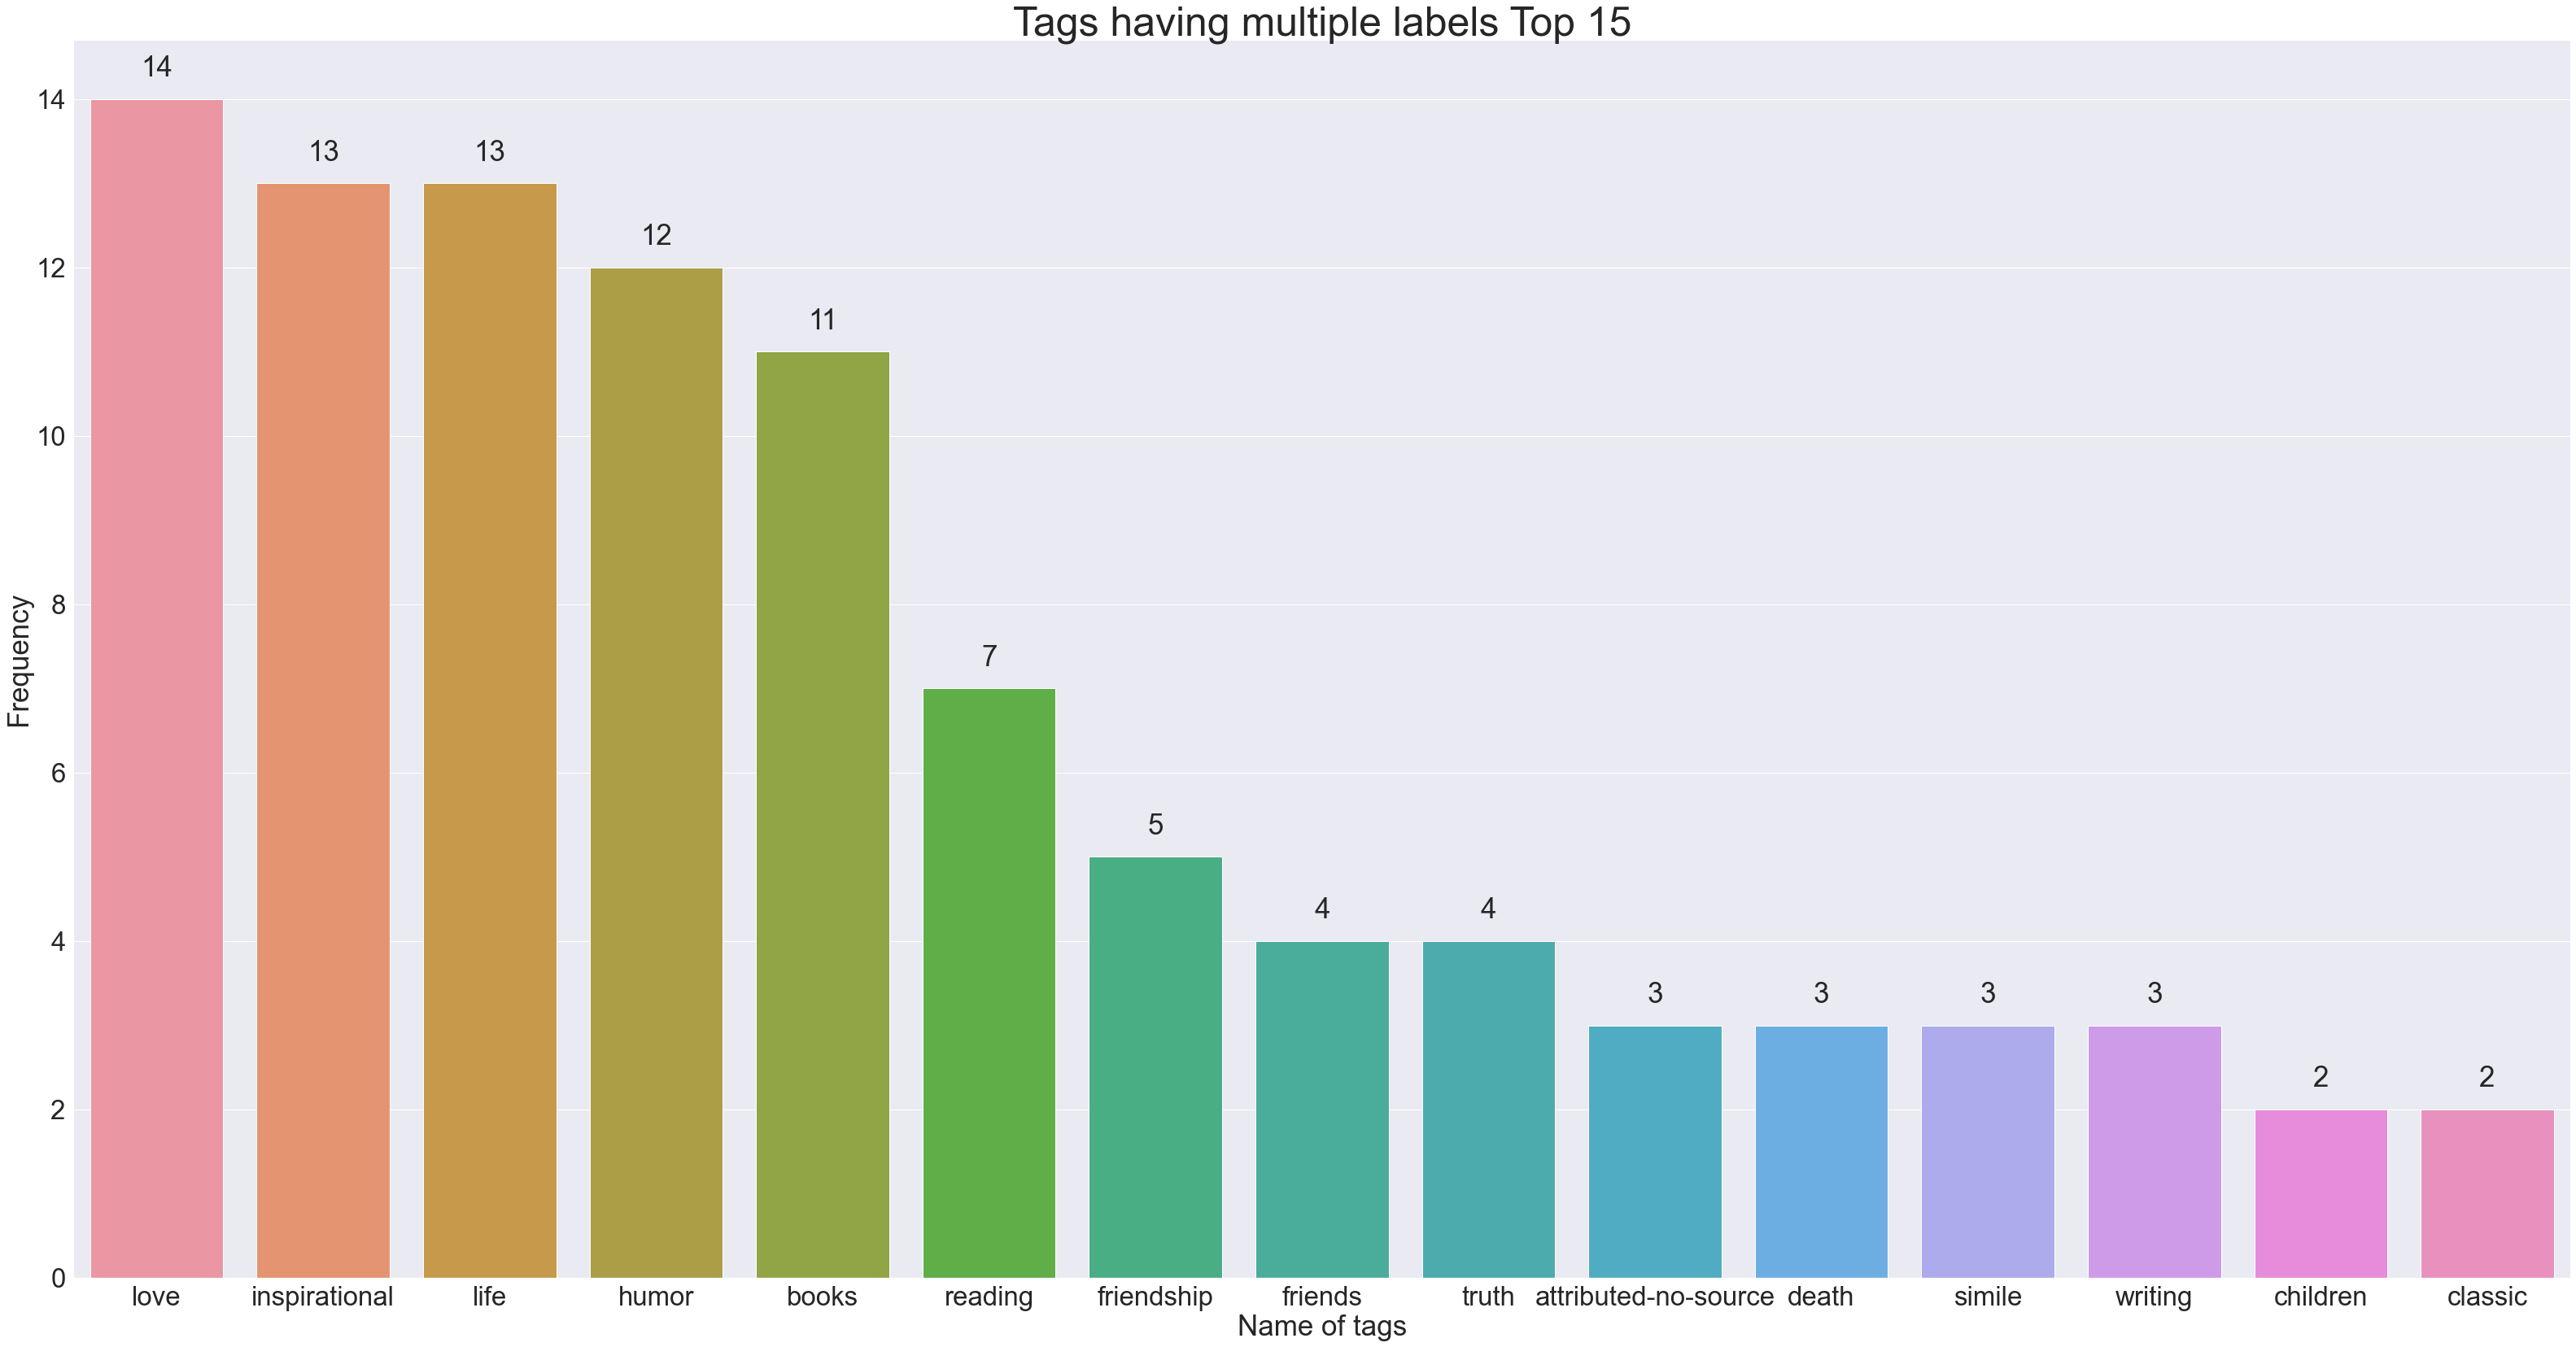

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

x = top15_tags
y = []
for i in top15_tags:
    y.append(sort_tags_dict[i])

sns.set(font_scale = 3)
plt.figure(figsize=(55,28))
ax = sns.barplot(x, y)
plt.title("Tags having multiple labels Top 15", fontsize=50)
plt.ylabel('Frequency', fontsize=35)
plt.xlabel('Name of tags', fontsize=35)

#adding the text labels
rects = ax.patches
labels = y
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+1/5, label, ha='center', va='bottom', fontsize=35)
plt.show()

In [44]:
#bring data frames together
df_all = df.merge(binary_labels, how='inner', left_index=True, right_index=True)
df_all

,content,author,tags,link_author,tags_new,abilities,activism,adulthood,adventure,age,...,unhappy-marriage,value,wander,wisdom,women,world,write,writers,writing,yourself
0,The world as we have created it is a process o...,Albert Einstein,"change,deep-thoughts,thinking,world",https://quotes.toscrape.com/author/Albert-Eins...,"[change, deep-thoughts, thinking, world]",0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,"It is our choices, Harry, that show what we tr...",J.K. Rowling,"abilities,choices",https://quotes.toscrape.com/author/J-K-Rowling/,"[abilities, choices]",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,There are only two ways to live your life. One...,Albert Einstein,"inspirational,life,live,miracle,miracles",https://quotes.toscrape.com/author/Albert-Eins...,"[inspirational, life, live, miracle, miracles]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"The person, be it gentleman or lady, who has n...",Jane Austen,"aliteracy,books,classic,humor",https://quotes.toscrape.com/author/Jane-Austen/,"[aliteracy, books, classic, humor]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Imperfection is beauty, madness is genius and ...",Marilyn Monroe,"be-yourself,inspirational",https://quotes.toscrape.com/author/Marilyn-Mon...,"[be-yourself, inspirational]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,To die will be an awfully big adventure.,J.M. Barrie,"adventure,love",https://quotes.toscrape.com/author/J-M-Barrie/,"[adventure, love]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93,It takes courage to grow up and become who you...,E.E. Cummings,courage,https://quotes.toscrape.com/author/E-E-Cummings/,[courage],0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
94,But better to get hurt by the truth than comfo...,Khaled Hosseini,life,https://quotes.toscrape.com/author/Khaled-Hoss...,[life],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,You never really understand a person until you...,Harper Lee,better-life-empathy,https://quotes.toscrape.com/author/Harper-Lee/,[better-life-empathy],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# select column
df_all = df_all[["content", "tags"] + top15_tags]
df_all

,content,tags,love,inspirational,life,humor,books,reading,friendship,friends,truth,attributed-no-source,death,simile,writing,children,classic
0,The world as we have created it is a process o...,"change,deep-thoughts,thinking,world",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"It is our choices, Harry, that show what we tr...","abilities,choices",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,There are only two ways to live your life. One...,"inspirational,life,live,miracle,miracles",0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,"The person, be it gentleman or lady, who has n...","aliteracy,books,classic,humor",0,0,0,1,1,0,0,0,0,0,0,0,0,0,1
4,"Imperfection is beauty, madness is genius and ...","be-yourself,inspirational",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,To die will be an awfully big adventure.,"adventure,love",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
93,It takes courage to grow up and become who you...,courage,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0
94,But better to get hurt by the truth than comfo...,life,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
95,You never really understand a person until you...,better-life-empathy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### คัดให้เหลือเฉพาะที่ใช้ในการวิเคราะห์
- AllArticles_OnlyHeading
- AllArticles_OnlyContent
- AllArticles_HeadingPlusContent
- Category

In [46]:
# AllArticles_OnlyHeading = df['title']
AllArticles_OnlyContent = df_all['content']
# AllArticles_HeadingPlusContent = df_all[['title','content']]
tags = df_all['tags']

**csv**

In [47]:
# AllArticles_OnlyHeading.to_csv('datastore/AllArticles_OnlyHeading.csv', index=False)

In [48]:
AllArticles_OnlyContent.to_csv('datastore/AllArticles_OnlyContent.csv', index=False)

In [49]:
# AllArticles_HeadingPlusContent.to_csv('datastore/AllArticles_HeadingPlusContent.csv', index=False)

In [50]:
tags.to_csv('target/tags.csv', index=False)

**txt**

In [51]:
# AllArticles_OnlyHeading.to_csv(r'AllArticles_OnlyHeading.txt', header=None, index=None, sep=' ', mode='a')

In [52]:
AllArticles_OnlyContent.to_csv(r'AllArticles_OnlyContent.txt', header=None, index=None, sep=' ', mode='a')

In [53]:
# AllArticles_HeadingPlusContent.to_csv(r'AllArticles_HeadingPlusContent.txt', header=None, index=None, sep=' ', mode='a')

In [54]:
tags.to_csv(r'target/tags.txt', header=None, index=None, sep=' ', mode='a')

In [55]:
binary_labels.to_csv(r'target/tags3.txt', header=None, index=None, sep=' ', mode='a')

In [56]:
#-----------------------------------------Tokenizer and WordNet Lemmatizer with POS (part of speech)--------------------------------------
def lemma_tokenizer_w_pos_tag(text):
    # define a nested function for converting POS tag for Lemmatizer
    def convert_tags(tag):
        if tag == 'vbd' or tag == 'vbg' or tag == 'vbz':
            return 'v'
        else: 
            return 'n'
    
    #-----------------------------------------------Using WordNet Lemmatizer-----------------------------------------
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    tokens_with_pos_tag = nltk.pos_tag(tokens)

    # then use NLTK to perform lemmatisation on each token
    lemmatizer = nltk.WordNetLemmatizer()
    lemma_tokens = []
    for token in tokens_with_pos_tag:
        new_tag = convert_tags(token[1].lower())
        lemma_tokens.append(lemmatizer.lemmatize(token[0], new_tag))
    
    return lemma_tokens

In [57]:
fin = open("AllArticles_OnlyContent.txt","r", encoding="utf8")
raw_documents = fin.readlines()
fin.close()
print("Read %d raw text documents" % len(raw_documents))

Read 188 raw text documents


In [58]:
# with open("datastore/AllArticles_OnlyContent.txt","r", encoding="utf8") as f:
#     raw_documents = f.read().splitlines() #ใช้แยก string ที่จุดขึ้นบรรทัดใหม่คือ จุดที่มี '\n' แล้วคืนค่ากลับมาเป็นข้อมูลประเภท list
# f.close()
# print("Read %d raw text documents" % len(raw_documents))

In [59]:
raw_documents[0]

'"The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking."\n'

In [60]:
df_all['content'][0]

'The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.'

In [61]:
# pd.Series(y).value_counts()

In [62]:
lemma_tokenizer_w_pos_tag(df_all['content'][0])

['The',
 'world',
 'a',
 'we',
 'have',
 'created',
 'it',
 'be',
 'process',
 'of',
 'our',
 'think',
 'It',
 'cannot',
 'be',
 'changed',
 'without',
 'change',
 'our',
 'thinking']

In [63]:
# df_all['love'][1]
df_all.columns[2::]

Index(['love', 'inspirational', 'life', 'humor', 'books', 'reading',
       'friendship', 'friends', 'truth', 'attributed-no-source', 'death',
       'simile', 'writing', 'children', 'classic'],
      dtype='object')

In [64]:
df_all.shape

(94, 17)

In [65]:
# # def y_tags()
# for j in range(94):
#     for i in df_all.columns[2::]:
#         print(df_all[i][j])

# <span style="color:red">K-Nearest Neighbors<span>

In [66]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Pin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [67]:
top15_tags

['love',
 'inspirational',
 'life',
 'humor',
 'books',
 'reading',
 'friendship',
 'friends',
 'truth',
 'attributed-no-source',
 'death',
 'simile',
 'writing',
 'children',
 'classic']

In [68]:
from sklearn.model_selection import train_test_split

def train_test_data(tags_name):
    x = df_all['content']
#     x = raw_documents
    y = df_all[tags_name]
    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.1) #, shuffle=True
    return X_train, X_test, y_train, y_test

In [69]:
X_train, X_test, y_train, y_test = train_test_data('love')

In [70]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(84,)
(10,)
(84,)
(10,)


In [71]:
pipe = Pipeline([
    ('vect', CountVectorizer(stop_words="english",min_df = 0,tokenizer=lemma_tokenizer_w_pos_tag)),
    ('tfidf', TfidfTransformer()),
]).fit(X_train)

In [72]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,3),min_df = 0, 
                             stop_words = 'english', sublinear_tf=True, lowercase=True)

In [73]:
params = { 
    'n_neighbors' : list(np.arange(1,50,2)),
    'weights' : ['uniform', 'distance'], 
    'metric' : ['euclidean', 'manhattan'] 
}

Tunning parameter 

In [74]:
from numpy import mean
from numpy import std
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

accuracy_knn_list = []
precision_knn_list = []
recall_knn_list = []

for tags_name in top15_tags:
    X_train, X_test, y_train, y_test = train_test_data(tags_name)
    X_train = pipe.transform(X_train)
    X_new_tfidf = pipe.transform(X_test)

#     folds = 5 
    knn = KNeighborsClassifier() 
    skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001) 
    knn_grid = GridSearchCV(knn, params, verbose = 3, cv=skf.split(X_train,y_train), n_jobs = -1)
    knn_grid.fit(X_train, y_train);
#     print(knn_grid.best_params_)
#     k_list.append(knn_grid.best_params_['n_neighbors'])
    
    
    knn=KNeighborsClassifier(metric=knn_grid.best_params_['metric'], 
                             n_neighbors=knn_grid.best_params_['n_neighbors'], 
                             weights=knn_grid.best_params_['weights'])
    knn.fit(X_train, y_train)
    cv = LeaveOneOut()
    scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=cv, n_jobs = -1)
    accuracy_knn_list.append(mean(scores))
    print('%s -> Accuracy: %.3f (%.3f)' % (tags_name ,mean(scores), std(scores)))
    
    knn_pred = knn.predict(X_new_tfidf)
    precision = metrics.precision_score(y_test, knn_pred, average='macro')
    precision_knn_list.append(precision)
    print('Precision Score: %.3f' % precision)
    
    recall = metrics.recall_score(y_test, knn_pred, average='macro')
    recall_knn_list.append(recall)
    print('recall Score: %.3f' % recall)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.6s finished


love -> Accuracy: 0.881 (0.324)
Precision Score: 0.400
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


inspirational -> Accuracy: 0.893 (0.309)
Precision Score: 0.300
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


life -> Accuracy: 0.869 (0.337)
Precision Score: 0.400
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


humor -> Accuracy: 0.869 (0.337)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


books -> Accuracy: 0.893 (0.309)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished


reading -> Accuracy: 0.929 (0.258)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


friendship -> Accuracy: 0.940 (0.237)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


friends -> Accuracy: 0.964 (0.186)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


truth -> Accuracy: 0.952 (0.213)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished


attributed-no-source -> Accuracy: 0.976 (0.152)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


death -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


simile -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


writing -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


children -> Accuracy: 0.988 (0.108)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


classic -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


In [75]:
recall_knn_list

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0]

In [76]:
data = {'Tags': np.array(top15_tags), 'Accuracy': np.array(accuracy_knn_list), 
        'Precision': np.array(precision_knn_list), 'Recall': np.array(recall_knn_list)}
df_knn = pd.DataFrame(data=data)
df_knn = df_knn.sort_values(by=['Precision'], ascending=False).reset_index(drop=True)

# เพิ่ม Row ที่เป็นค่าเฉลี่ยของ Accuracy
df_knn = df_knn.append({'Tags' : 'Average' , 
                        'Accuracy' : (sum(accuracy_knn_list)/15), 
                        'Precision' : (sum(precision_knn_list)/15),
                        'Recall': (sum(recall_knn_list)/15)}, ignore_index=True)

# highlight row in Dataframe
color = (df_knn['Tags'] == 'Average').map({True: 'background-color: yellow', False: ''})
df_knn.style.apply(lambda s: color)

,Tags,Accuracy,Precision,Recall
0,friendship,0.940476,1.000000,1.000000
1,truth,0.952381,1.000000,1.000000
2,death,0.964286,1.000000,1.000000
3,simile,0.976190,1.000000,1.000000
4,writing,0.964286,1.000000,1.000000
5,classic,0.976190,1.000000,1.000000
6,humor,0.869048,0.450000,0.500000
7,books,0.892857,0.450000,0.500000
8,reading,0.928571,0.450000,0.500000
9,friends,0.964286,0.450000,0.500000


KNN Tunning parameter (weighting)

In [77]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [78]:
from numpy import mean
from numpy import std
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


accuracy_knn_list = []
precision_knn_list = []
recall_knn_list = []

for tags_name in top15_tags:
    X_train, X_test, y_train, y_test = train_test_data(tags_name)
    X_train = vectorizer.fit_transform(X_train)
    X_new_tfidf = vectorizer.transform(X_test)

    folds = 5 
    knn = KNeighborsClassifier() 
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001) 
    knn_grid = GridSearchCV(knn, params, verbose = 3, cv=skf.split(X_train,y_train), n_jobs = -1)
    knn_grid.fit(X_train, y_train);
#     print(knn_grid.best_params_)
#     k_list.append(knn_grid.best_params_['n_neighbors'])
    
    
    knn=KNeighborsClassifier(metric=knn_grid.best_params_['metric'], 
                             n_neighbors=knn_grid.best_params_['n_neighbors'], 
                             weights=knn_grid.best_params_['weights'])
    knn.fit(X_train, y_train)
    cv = LeaveOneOut()
    scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=cv, n_jobs = -1)
    accuracy_knn_list.append(mean(scores))
    print('%s -> Accuracy: %.3f (%.3f)' % (tags_name ,mean(scores), std(scores)))
    
    knn_pred = knn.predict(X_new_tfidf)
    precision = metrics.precision_score(y_test, knn_pred, average='macro')
    precision_knn_list.append(precision)
    print('Precision Score: %.3f' % precision)
    
    recall = metrics.recall_score(y_test, knn_pred, average='macro')
    recall_knn_list.append(recall)
    print('recall Score: %.3f' % recall)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


love -> Accuracy: 0.869 (0.337)
Precision Score: 0.400
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


inspirational -> Accuracy: 0.893 (0.309)
Precision Score: 0.300
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


life -> Accuracy: 0.881 (0.324)
Precision Score: 0.400
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


humor -> Accuracy: 0.881 (0.324)
Precision Score: 0.444
recall Score: 0.444
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


books -> Accuracy: 0.857 (0.350)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


reading -> Accuracy: 0.929 (0.258)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


friendship -> Accuracy: 0.929 (0.258)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


friends -> Accuracy: 0.964 (0.186)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


truth -> Accuracy: 0.952 (0.213)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


attributed-no-source -> Accuracy: 0.976 (0.152)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


death -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


simile -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


writing -> Accuracy: 0.964 (0.186)
Precision Score: 1.000
recall Score: 1.000
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


children -> Accuracy: 0.988 (0.108)
Precision Score: 0.450
recall Score: 0.500
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


classic -> Accuracy: 0.976 (0.152)
Precision Score: 1.000
recall Score: 1.000


In [79]:
data = {'Tags': np.array(top15_tags), 'Accuracy': np.array(accuracy_knn_list), 
        'Precision': np.array(precision_knn_list), 'Recall': np.array(recall_knn_list)}
df_knn = pd.DataFrame(data=data)
df_knn = df_knn.sort_values(by=['Precision'], ascending=False).reset_index(drop=True)

# เพิ่ม Row ที่เป็นค่าเฉลี่ยของ Accuracy
df_knn = df_knn.append({'Tags' : 'Average' , 
                        'Accuracy' : (sum(accuracy_knn_list)/15), 
                        'Precision' : (sum(precision_knn_list)/15),
                        'Recall': (sum(recall_knn_list)/15)} , ignore_index=True)

# highlight row in Dataframe
color = (df_knn['Tags'] == 'Average').map({True: 'background-color: yellow', False: ''})
df_knn.style.apply(lambda s: color)

,Tags,Accuracy,Precision,Recall
0,friendship,0.928571,1.000000,1.000000
1,truth,0.952381,1.000000,1.000000
2,death,0.964286,1.000000,1.000000
3,simile,0.976190,1.000000,1.000000
4,writing,0.964286,1.000000,1.000000
5,classic,0.976190,1.000000,1.000000
6,books,0.857143,0.450000,0.500000
7,reading,0.928571,0.450000,0.500000
8,friends,0.964286,0.450000,0.500000
9,attributed-no-source,0.976190,0.450000,0.500000
